In [209]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.interpolate import interp1d
# normalized p-y curves
y_norm=np.arange(0,10.1,0.1)
p_norm=np.zeros_like(y_norm)
for i,j in enumerate(y_norm): #ask
    if y_norm[i] <= 8:
        p_norm[i]=0.5*y_norm[i]**(1/3)
    else:
        p_norm[i]=0.5*8**(1/3) #P/P_ult
fnp=interp1d(y_norm,p_norm,kind='linear') #function to read P/P_ult
#undrained shear strength profile
d=np.arange(0,101,1) #divide pile length to 1 feet segment and 101 nodes
s_u=100+10*d #calculate distribution of shear strength
#calculate P_ult profile
rho_soil_b=62.6 #effective unit weight (125-62.4) in psf
d_m=3 #diameter of the pile
n_p=3+(rho_soil_b*d/s_u)+(0.5*d/d_m) #calculate distribution of N_p
n_p=np.where(n_p>9,9,n_p) #replacing Np>9 with 9
p_ult=n_p*s_u*d_m #calculate distribution of P_ult in lb
p_ult=p_ult.reshape(len(p_ult),1)
#calculate y50 based on shear strength profile
e50=[] #initialize empty array of e50
s_u_si=s_u*0.04788025888888984 #convert shear strength profile psf to kN/m2
#assigning e50 values depending on the shear strength (refer to table used)
for i,j in enumerate(s_u_si):
    if s_u_si[i]<=24:
        e50.append(0.02)
    elif s_u_si[i]>24 and s_u_si[i]<48:
        e50.append(0.01)
    else:
        e50.append(0.006)
e50=np.array(e50) #turn to array
y50=e50*2.5*d_m #calculate y50 in feet
#define acceptale tolerance
tol=0.001*d_m #tolerance assigned of 0.1% of diameter
#imposing BC Floating Pile and create stiffness matrix 
k=np.array([0.0]*(len(d)**2)).reshape(len(d),len(d)) #initialize empty k stiffness
k[0,0]=1
k[1,0],k[1,1],k[1,2]=1,-2,1
k[len(k)-1,len(k)-1],k[len(k)-1,len(k)-2],k[len(k)-1,len(k)-3]=1,-2,1
k[len(k)-2,len(k)-1],k[len(k)-2,len(k)-2],k[len(k)-2,len(k)-3],k[len(k)-2,len(k)-4]=-1,3,-3,1
for i,j in enumerate(k[2:len(k)-2]):
    k[i+2,i]=1
    k[i+2,i+1]=-4
    k[i+2,i+3]=-4
    k[i+2,i+4]=1
#define initial trial for displacement profile
y0=2/12 #top displacement at 2 inch (converted to feet)
temp_y=y0-(y0/max(d))*d #distribution of displacement along the pile
temp_y[len(temp_y)-1]=0.001 #assign 0.001 ft displacement at the tip
temp_y=temp_y.reshape(len(temp_y),1)
delta_x=1#distance between nodes (ft) (consistent here)
inertia_m=(math.pi/64)*((3**4)-(2.75**4)) #calculate I in ft^4
e_mod=4176000000 #in psf
load_v=np.array([0.0]*(len(d))).reshape(len(d),1) #initialize empty k stiffness
load_v[0]=np.float64(y0) #assigning boundary condition to the load vector
## Main Iterative Loop ##
counter=0
while counter<50:
    counter+=1
    y_ratn=temp_y/y50.reshape(len(y50),1)
    y_ratn=y_ratn.reshape(len(y_ratn),1)
#     p_n=p_ult*0.5*(abs(y_ratn))**(1/3)
    p_n=fnp(abs(y_ratn))*p_ult
    k_s=p_n/abs(temp_y)
    for i,j in enumerate(k[2:len(k)-2]):
        k[i+2,i+2]=6+(k_s[i+2]*(delta_x**4))/(inertia_m*e_mod)
    new_y=np.linalg.solve(k,load_v)
    diff=np.asarray(abs(new_y-temp_y))
    if max(diff)>tol:
        temp_y=new_y
    elif max(diff)<=tol:
        break
        


In [ ]:
# y=y0-(y0/max(d))*d #distribution of displacement along the pile
# y[len(y)-1]=0.001 #assign 0.001 ft displacement at the tip
# y_rat=y/y50 #ratio of y/y50 for calculation purposes
#calculate new p
# p_n=p_ult*0.5*(y_rat)**(1/3) #compute p along the depth of the pile using y trial
# k_s=p_n/abs(y) #compute stiffness per nodes based on p_n and y in lb/ft
# #p=fnp(y_rat)*p_ult
# #reiterate diagonal (put to iterative loop)
# for i,j in enumerate(k[2:len(k)-2]):
#     k[i+2,i+2]=6+(k_s[i+2]*(delta_x**4))/(inertia_m*e_mod)
# temp_y=np.linalg.solve(k,load_v)
# diff=np.asarray(abs(temp_y-(y.reshape(len(y),1))))
# p_ult=p_ult.reshape(len(p_ult),1)

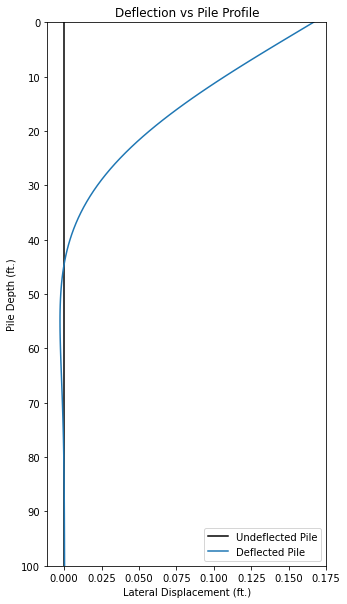

In [210]:
import matplotlib
matplotlib.rc('figure', figsize=(5, 10))
plt.ylim(max(d),0)
plt.yticks(np.arange(0,110,10))
x=[0]*len(d)
plot_y=y0-(y0/max(d))*d #distribution of displacement along the pile
plot_y[len(plot_y)-1]=0.001 #assign 0.001 ft displacement at the tip
plot_y=temp_y.reshape(len(plot_y),1)
plt.plot(x,d,'k')
plt.plot(new_y,d)
plt.title('Deflection vs Pile Profile')#
plt.xlabel('Lateral Displacement (ft.)')#
plt.ylabel('Pile Depth (ft.)')
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.legend(['Undeflected Pile', 'Deflected Pile'], loc='lower right')
plt.savefig('freehead.png', dpi=600)


In [211]:
#constructing differential operator and assigning BCs
k_m=np.array([0.0]*(len(d)**2)).reshape(len(d),len(d))
k[0,0],k[0,1],k[0,2]=1,-2,1
k[len(k)-1,len(k)-1],k[len(k)-1,len(k)-2],k[len(k)-1,len(k)-3]=1,-2,1
for i,j in enumerate(k_m[1:len(k_m)-1]):
    k_m[i+1,i]=1
    k_m[i+1,i+1]=-2
    k_m[i+1,i+2]=1
m_t=np.dot(k_m,new_y)
m=(inertia_m*e_mod*m_t)/(delta_x**2)

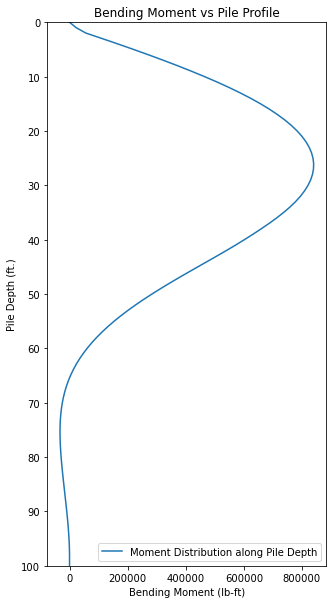

In [212]:
import matplotlib
matplotlib.rc('figure', figsize=(5, 10))
plt.ylim(max(d),0)
plt.yticks(np.arange(0,110,10))
m[1]=5.62836023e+04/2.5
# x=[0]*len(d)
# plot_y=y0-(y0/max(d))*d #distribution of displacement along the pile
# plot_y[len(plot_y)-1]=0.001 #assign 0.001 ft displacement at the tip
# plot_y=temp_y.reshape(len(plot_y),1)
# plt.plot(x,d,'k')
plt.plot(m,d)
plt.title('Bending Moment vs Pile Profile')#
plt.xlabel('Bending Moment (lb-ft)')#
plt.ylabel('Pile Depth (ft.)')
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.legend(['Moment Distribution along Pile Depth'], loc='lower right')
plt.savefig('freeheadm.png', dpi=600)

In [213]:
#constructing differential operator and assigning BCs
k_v=np.array([0.0]*(len(d)**2)).reshape(len(d),len(d))
k_v[0,0],k_v[0,1],k_v[0,2],k_v[0,3]=-1,3,-3,1 #forward
k_v[1,1],k_v[1,2],k_v[1,3],k_v[1,4]=-1,3,-3,1 #forward
k_v[len(k)-1,len(k_v)-1],k_v[len(k_v)-1,len(k_v)-2],k_v[len(k_v)-1,len(k_v)-3],k_v[len(k_v)-2,len(k_v)-4]=0,0,0,0
k_v[len(k)-2,len(k_v)-1],k_v[len(k_v)-2,len(k_v)-2],k_v[len(k_v)-2,len(k_v)-3],k_v[len(k_v)-2,len(k_v)-4]=-1,3,-3,1
for i,j in enumerate(k_v[2:len(k_v)-2]):
    k_v[i+2,i]=-1
    k_v[i+2,i+1]=2
    k_v[i+2,i+3]=-2
    k_v[i+2,i+4]=1
v_t=np.dot(k_v,new_y)
v=np.array([0.0]*(len(new_y))).reshape(len(new_y),1)
v[0:2]=(inertia_m*e_mod*v_t[0:2])/(delta_x**2)
v[len(v)-2:len(v)]=(inertia_m*e_mod*v_t[len(v_t)-2:len(v_t)])/(delta_x**3)
v[2:len(v)-2]=(inertia_m*e_mod*v_t[2:len(v_t)-2])/(2*delta_x**3)

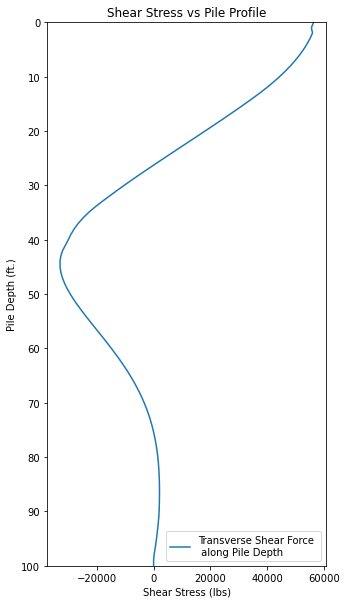

In [214]:
import matplotlib
matplotlib.rc('figure', figsize=(5, 10))
plt.ylim(max(d),0)
plt.yticks(np.arange(0,110,10))
# x=[0]*len(d)
# plot_y=y0-(y0/max(d))*d #distribution of displacement along the pile
# plot_y[len(plot_y)-1]=0.001 #assign 0.001 ft displacement at the tip
# plot_y=temp_y.reshape(len(plot_y),1)
# plt.plot(x,d,'k')
plt.plot(v,d)
plt.title('Shear Stress vs Pile Profile')#
plt.xlabel('Shear Stress (lbs)')#
plt.ylabel('Pile Depth (ft.)')
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.legend(['Transverse Shear Force \n along Pile Depth'], loc='lower right')
plt.savefig('freeheadv.png', dpi=600)

In [252]:
k_w=np.array([0.0]*(len(d)**2)).reshape(len(d),len(d))
for i,j in enumerate(k_w[0:len(k_w)-2]):
    k_w[i+1,i+1]=-1
    k_w[i+1,i+2]=1
# w_t=np.dot(k_w,new_y)
# w=(inertia_m*e_mod*w_t)/(delta_x**4)
w_t=np.dot(k_w,v)
# w=(inertia_m*e_mod*w_t)/(delta_x**4)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0., -1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -1.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0., -1.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

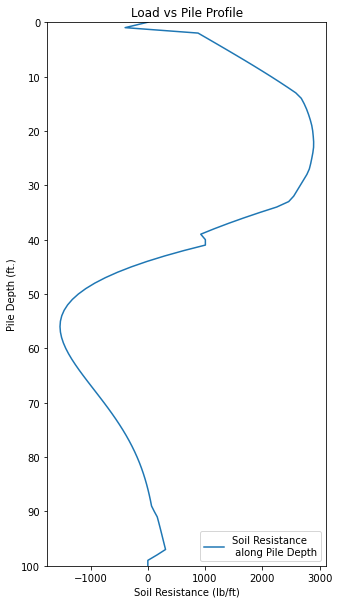

In [255]:
import matplotlib
matplotlib.rc('figure', figsize=(5, 10))
plt.ylim(max(d),0)
plt.yticks(np.arange(0,110,10))
# x=[0]*len(d)
# plot_y=y0-(y0/max(d))*d #distribution of displacement along the pile
# plot_y[len(plot_y)-1]=0.001 #assign 0.001 ft displacement at the tip
# plot_y=temp_y.reshape(len(plot_y),1)
# plt.plot(x,d,'k')
plt.plot(-w_t,d)
plt.title('Load vs Pile Profile')#
plt.xlabel('Soil Resistance (lb/ft)')#
plt.ylabel('Pile Depth (ft.)')
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.legend(['Soil Resistance \n along Pile Depth'], loc='lower right')
plt.savefig('freeheadw.png', dpi=600)

In [1]:
import os
os.getcwd()

'C:\\Users\\hernawa2'